# 1. Import and data processing

Import all necessary libraries

In [15]:
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset, random_split

Load the training data

In [16]:
data = np.load("./data.npy")

Define constants that describe the data and model

In [17]:
CONTEXT_SIZE = 10
ALPHABET = list("abcdefghijklmnopqrstuvwxyz")
ALPHABET_SIZE = len(ALPHABET)
TRAINING_DATA_SIZE = 0.9

# +1 is for unknown characters
VOCAB_SIZE = ALPHABET_SIZE + 1

EMBEDDING_DIM = 16

INPUT_SEQ_LEN = CONTEXT_SIZE
OUTPUT_SIZE = VOCAB_SIZE

BATCH_SIZE = 2048 * 2 * 2

EPOCHS = 50
LEARNING_RATE = 1e-3

Process the data

In [18]:
# Input: embeddings of the previous 10 letters
# shape: (num_samples, CONTEXT_SIZE)
X = data[:, :CONTEXT_SIZE]

# Target: current letter index
# shape: (num_samples,)
y = data[:, CONTEXT_SIZE]

# Torch dataset (important: use long/int64 for indices)
X_tensor = torch.tensor(X, dtype=torch.long)   # for nn.Embedding
y_tensor = torch.tensor(y, dtype=torch.long)   # for classification target

dataset = TensorDataset(X_tensor, y_tensor)

train_len = int(TRAINING_DATA_SIZE * len(dataset))
train_set, test_set = random_split(dataset, [train_len, len(dataset) - train_len])

train_loader = DataLoader(train_set, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_set, batch_size=BATCH_SIZE)

# 2. Model

In [19]:
from dataclasses import dataclass

@dataclass
class MlpHiddenLayer():
    size: int
    activation_function: nn.Module

In [20]:
class MLP(nn.Module):
    def __init__(self, *,
                 embedding_count: int,
                 embedding_dimension_size: int,
                 input_shape_size: int,
                 output_shape: int,
                 hidden_layers: list[MlpHiddenLayer]
                 ):

        super().__init__()

        self.embedding_count = embedding_count
        self.embedding_dimension_size = embedding_dimension_size
        self.input_shape_size = input_shape_size
        self.output_shape = output_shape
        self.hidden_layers = hidden_layers

        layers = [
            nn.Embedding(num_embeddings=embedding_count, embedding_dim=embedding_dimension_size),
            nn.Flatten(),
        ]

        input_dimensions = input_shape_size

        for layer in hidden_layers:
            layers.append(nn.Linear(input_dimensions, layer.size))
            layers.append(layer.activation_function())
            input_dimensions = layer.size

        layers.append(nn.Linear(input_dimensions, output_shape))

        self.net = nn.Sequential(*layers)

    def forward(self, x):
        return self.net(x)

In [21]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


# 3. Training

Create fresh instance of the model

## Mass testing all hyperparams

In [14]:
from itertools import product

MHL = MlpHiddenLayer

learning_rates = [1e-2, 5e-3, 1e-3, 5e-4, 1e-4]
layer_sizes = [32, 64, 128, 256]
depths = [1, 2, 3]
activation_functions = [nn.ReLU]

all_models = []

def train_model(model, optimizer):
    for epoch in range(EPOCHS):
        model.train()
        total_loss = 0
        for batch_X, batch_y in train_loader:
            batch_X, batch_y = batch_X.to(device), batch_y.to(device)
            optimizer.zero_grad()
            output = model(batch_X)
            loss = criterion(output, batch_y)
            loss.backward()
            optimizer.step()
            total_loss += loss.item() / batch_X.size(0)

def test_model(model):
    model.eval()
    correct_top1 = 0
    correct_top3 = 0
    correct_top5 = 0
    total = 0

    with torch.no_grad():
        for batch_X, batch_y in test_loader:
            batch_X, batch_y = batch_X.to(device), batch_y.to(device)
            outputs = model(batch_X)

            _, top_preds = outputs.topk(5, dim=1)

            for true, top5 in zip(batch_y, top_preds):
                total += 1
                if true == top5[0]:
                    correct_top1 += 1
                if true in top5[:3]:
                    correct_top3 += 1
                if true in top5:
                    correct_top5 += 1

    top1_acc = correct_top1 / total
    top3_acc = correct_top3 / total
    top5_acc = correct_top5 / total

    return top1_acc, top3_acc, top5_acc

criterion = nn.CrossEntropyLoss()

results = []

config_id = 0
for act_fn in activation_functions:
    for depth in depths:
        for size_combo in product(layer_sizes, repeat=depth):
            for learning_rate in learning_rates:
                hidden_layers = [MlpHiddenLayer(size=s, activation_function=act_fn) for s in size_combo]
                model = MLP(
                    hidden_layers=hidden_layers,
                    embedding_count=VOCAB_SIZE,
                    embedding_dimension_size=EMBEDDING_DIM,
                    input_shape_size=CONTEXT_SIZE * EMBEDDING_DIM,
                    output_shape=OUTPUT_SIZE,
                ).to(device)

                optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
                train_model(model, optimizer)
                top1, top3, top5 = test_model(model)

                results.append({
                    "config_id": config_id,
                    "activation": act_fn.__name__,
                    "layer_sizes": size_combo,
                    "learning_rate": learning_rate,
                    "top1_acc": top1,
                    "top3_acc": top3,
                    "top5_acc": top5
                })

                print(f"[#{config_id}] {act_fn.__name__} {size_combo} lr={learning_rate:.0e} → top1={top1:.2f}, top3={top3:.2f}, top5={top5:.2f}")
                config_id += 1

                del model
                torch.cuda.empty_cache()


print(results)



KeyboardInterrupt: 

## Model training

In [41]:
MHL = MlpHiddenLayer
Relu = nn.ReLU
Gelu = nn.GELU
Silu = nn.SiLU

sizes = [256, 128]


model = MLP(
    hidden_layers=[MHL(size=size, activation_function=Relu) for size in sizes],
    embedding_count=VOCAB_SIZE,
    embedding_dimension_size=EMBEDDING_DIM,
    input_shape_size=CONTEXT_SIZE * EMBEDDING_DIM,
    output_shape=OUTPUT_SIZE,
    ).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)


In [46]:
prev_loss = float("inf")
small_change_count = 0
SMALL_CHANGE_COUNT_TRIGGER = 5

TOO_SMALL_CHANGE = 1e-3

for epoch in range(EPOCHS):
    if small_change_count >= SMALL_CHANGE_COUNT_TRIGGER:
        print(f"# Loss has been too stagnant for {SMALL_CHANGE_COUNT_TRIGGER} epochs.\n## Ending now")
        break

    model.train()
    total_loss = 0
    correct = 0
    total = 0

    for batch_X, batch_y in train_loader:
        batch_X, batch_y = batch_X.to(device), batch_y.to(device)

        optimizer.zero_grad()
        output = model(batch_X)
        loss = criterion(output, batch_y)
        loss.backward()
        optimizer.step()

        total_loss += loss.item() * batch_X.size(0)  # Multiply by batch size to sum loss
        preds = torch.argmax(output, dim=1)
        correct += (preds == batch_y).sum().item()
        total += batch_X.size(0)

    avg_loss = total_loss / total
    accuracy = correct / total * 100
    print(f"[Epoch #{(epoch+1):02}] - Loss: {avg_loss:.5f} | Accuracy: {accuracy:.2f}%")

    if prev_loss - avg_loss < TOO_SMALL_CHANGE:
        small_change_count += 1
        print(f"# Small loss difference detected ({small_change_count}/{SMALL_CHANGE_COUNT_TRIGGER})")
    else:
        if small_change_count > 0:
            print("# Loss difference increased again. Resetting counter")
        small_change_count = 0

    prev_loss = avg_loss


[Epoch #01] - Loss: 1.48195 | Accuracy: 51.54%
[Epoch #02] - Loss: 1.48260 | Accuracy: 51.51%
# Small loss difference detected (1/5)
[Epoch #03] - Loss: 1.48176 | Accuracy: 51.56%
# Small loss difference detected (2/5)
[Epoch #04] - Loss: 1.48150 | Accuracy: 51.54%
# Small loss difference detected (3/5)
[Epoch #05] - Loss: 1.48147 | Accuracy: 51.56%
# Small loss difference detected (4/5)
[Epoch #06] - Loss: 1.48097 | Accuracy: 51.60%
# Small loss difference detected (5/5)
# Loss has been too stagnant for 5 epochs.
## Ending now


In [24]:
model.eval()
correct_top1 = 0
correct_top3 = 0
correct_top5 = 0
total = 0

with torch.no_grad():
    for batch_X, batch_y in test_loader:
        batch_X, batch_y = batch_X.to(device), batch_y.to(device)
        outputs = model(batch_X)

        _, top_preds = outputs.topk(5, dim=1)

        for true, top5 in zip(batch_y, top_preds):
            total += 1
            if true == top5[0]:
                correct_top1 += 1
            if true in top5[:3]:
                correct_top3 += 1
            if true in top5:
                correct_top5 += 1

top1_acc = correct_top1 / total
top3_acc = correct_top3 / total
top5_acc = correct_top5 / total

print(f"Top 1 prediction accuracy: {(top1_acc * 100):.2f}%")
print(f"Top 3 prediction accuracy: {(top3_acc * 100):.2f}%")
print(f"Top 5 prediction accuracy: {(top5_acc * 100):.2f}%")

Top 1 prediction accuracy: 49.92%
Top 3 prediction accuracy: 73.00%
Top 5 prediction accuracy: 82.72%


In [62]:
embeddings = model.net[0].weight.detach().cpu().numpy()

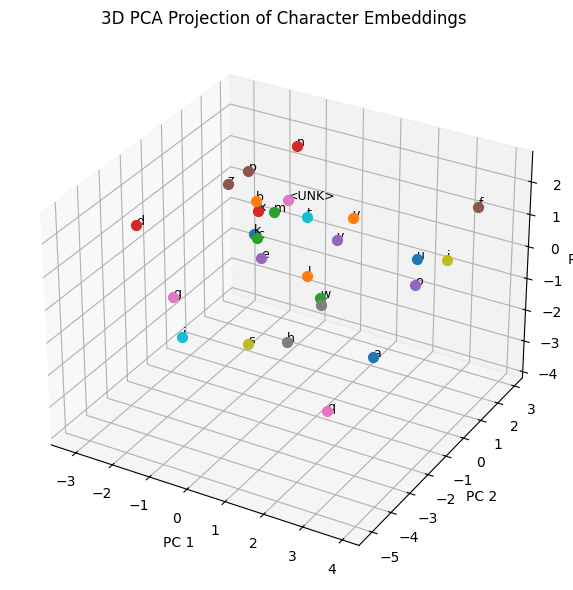

In [26]:
def pca_torch(X: torch.Tensor, n_components=3):
    # Center the data
    X = X - X.mean(dim=0)
    # Compute SVD
    U, S, V = torch.pca_lowrank(X, q=n_components)
    return torch.matmul(X, V[:, :n_components])

# Extract and reduce embeddings
embeddings = model.net[0].weight.detach().cpu()
reduced = pca_torch(embeddings, n_components=3)

# Plot using matplotlib 3D
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')

for i, label in enumerate(ALPHABET + ['<UNK>']):
    x, y, z = reduced[i]
    ax.scatter(x.item(), y.item(), z.item(), s=50)
    ax.text(x.item(), y.item(), z.item(), label, fontsize=9)

ax.set_title("3D PCA Projection of Character Embeddings")
ax.set_xlabel("PC 1")
ax.set_ylabel("PC 2")
ax.set_zlabel("PC 3")
plt.tight_layout()
plt.show()


In [29]:
import torch.onnx

FILENAME = "model.onnx"
model.eval()

dummy_input = torch.randint(0, VOCAB_SIZE, (1, CONTEXT_SIZE), dtype=torch.long).to(device)

torch.onnx.export(
    model,
    dummy_input,
    FILENAME,
    input_names=["input"],
    output_names=["output"],
    dynamic_axes={
        "input": {0: "batch_size"},
        "output": {0: "batch_size"},
    },
    opset_version=13
)

print(f"Export successful -> '{FILENAME}'")

Export successful -> 'model.onnx'
